In [3]:
# First approach to Smart Charging Phase 1 using PuLP.
# Modeled as a PuLP optimisation blending problem
# Started 20 Aug 2020
# Author: Sofia Taylor, Flexible Power Systems

import numpy as np
import pandas as pd
import datetime as dt
from pulp import *
import pickle
import global_variables as gv
import output_functions as of
import testdata_proc as pf
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import random
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.font_manager as font_manager
import lin_prog_functions as lpf
import testdata_proc as pf
import plotly.graph_objects as go
import plotly.io as pio
import os

In [20]:
run = 50
branch = 513
allocation = 14
ca = 'BAU'
site_capacity = {
        'BAU': 10000}
range_profile = pickle.load(open(
    'Outputs/LogsJLP/run{}/range_profiles'.format(run), 'rb'))
range_profile[['Output_BAU']].to_csv('Outputs/LogsJLP/run{}/20-10.WEVC.EV_profile_{}_run{}.0{}.ST.csv'.format(run, branch, run, allocation), header=['EV_charging_kWh'])
site_profile = pickle.load(
    open('Outputs/LogsJLP/run{}/site_summary'.format(run), 'rb'))
days_summary = pickle.load(open(
    'Outputs/LogsJLP/run{}/days_summary'.format(run), 'rb'))
empty_profs = pickle.load(open(
    'Outputs/LogsJLP/empty_profiles'.format(run), 'rb'))
status = pickle.load(
    open('Outputs/LogsJLP/run{}/status'.format(run),'rb'))
veh_agg = range_profile.groupby(['date','Vehicle_ID']).sum()

empty_profile = empty_profs[branch]

In [16]:
day_profile2 = range_profile.loc[
    dt.datetime(2020, 8, 10, 8, 0, 0):dt.datetime(2020, 8, 17, 7, 30, 0)]
status[status['Level_BAU']=='Magic']

,Level_BAU


In [17]:
# jour = pickle.load(
#     open(os.path.join(gv.LOGS, r'all_journeys'), 'rb'))
# journeys = jour[branch]
# journeys['Start_Time'] = journeys['Start_Time_of_Route'].dt.time
# journeys['End_Time'] = journeys['End_Time_of_Route'].dt.time
# # journeys.to_csv('Outputs/LogsJLP/run35/journeys457.csv')
# # journeys.loc[dt.datetime(2020, 6, 25)][['Start_Time', 'End_Time', 'Energy_Required', 'Vehicle_ID']]
# journeys.loc[dt.datetime(2020, 4, 9)][['Start_Time_of_Route', 'End_Time_of_Route', 'Energy_Required', 'Vehicle_ID', 'Route_Cost']]

In [18]:
# coulsdon_profile = day_profile3

In [19]:
day_profile3 = range_profile.loc[
    dt.datetime(2020, 8, 14, 8, 0, 0):dt.datetime(2020, 8, 15, 7, 30, 0)]

fig, axs = plt.subplots(
    1,
    figsize=(6,3.5),
    sharex=True, 
    gridspec_kw={'hspace':0.1})
ca='BAU'
x = day_profile3.unstack().index
cols = gv.CAT_COLS
colors = {1:gv.FPS_BLUE, 2:gv.FPS_YELLOW, 50:gv.FPS_YELLOW}
for v in [1, 2]:
    v_profile = day_profile3.loc[(slice(None), v), :]
    axs.plot(
        x, 
        v_profile[cols['OUTPUT'][ca]]*2,
        label = 'Vehicle {}'.format(v),
        c=colors[v])
# axs.plot(
#     x,
#     day_profile2[cols['OUTPUT'][ca]].groupby('from').mean()*2, linewidth=3,
#     label='Mean demand from all vehicles')
axs.legend(frameon=False)
axs.set_xlabel('Time', color=gv.FPS_BLUE)
axs.set_ylabel('Electricity Demand (kW)', color=gv.FPS_BLUE)
axs.set_title('{}'.format(gv.STORE_SPEC[branch]['N']),
              color=gv.FPS_BLUE, fontweight='bold')

time_form = DateFormatter("%H")
axs.xaxis.set_major_formatter(time_form)
fig.savefig('Outputs/LogsJLP/run{}/sample_profile_day.png'.format(run))
fig.show()

KeyError: 1

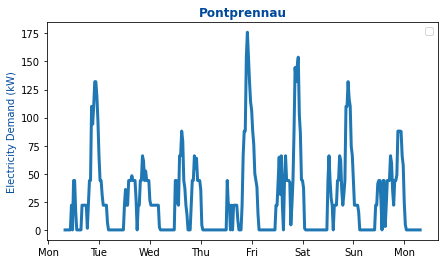

In [7]:
fig, axs = plt.subplots(
    1,
    figsize=(7,4),
    sharex=True, 
    gridspec_kw={'hspace':0.1})
ca='BAU'
x = day_profile2.unstack().index#.strftime('%a')
cols = gv.CAT_COLS

# axs.plot(
#     x, 
#     day_profile3.unstack()[cols['OUTPUT'][ca]]*2)
axs.legend(day_profile2.unstack()[cols['OUTPUT'][ca]].columns)
# axs.set_xlabel('Date', color=gv.FPS_BLUE)
axs.set_ylabel('Electricity Demand (kW)', color=gv.FPS_BLUE)
axs.set_title('{}'.format(gv.STORE_SPEC[branch]['N']),
                          color=gv.FPS_BLUE, fontweight='bold')

axs.plot(
    x,
    day_profile2[cols['OUTPUT'][ca]].groupby('from').sum()*2, linewidth=3)
date_form = DateFormatter("%a")
axs.xaxis.set_major_formatter(date_form)
# axs.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1))
fig.savefig('Outputs/LogsJLP/run{}/sample_profile_week.png'.format(run))
fig.show()

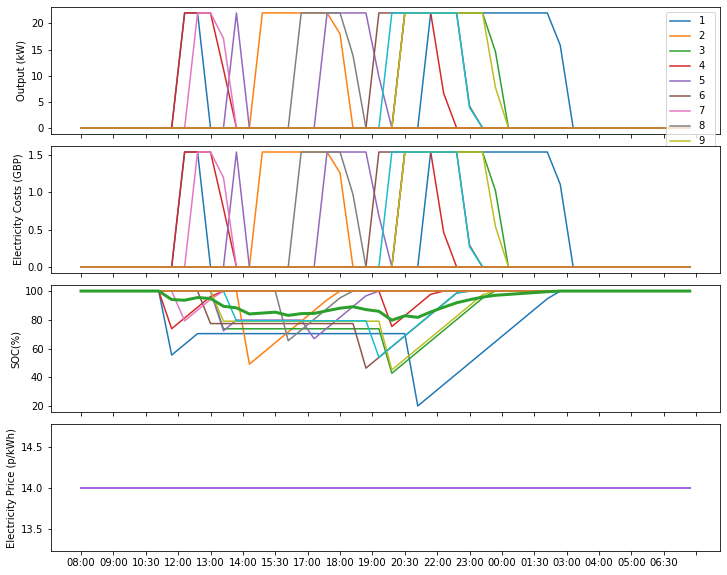

In [13]:
fig, axs = plt.subplots(
    4,
    figsize=(12,10),
    sharex=True, 
    gridspec_kw={'hspace':0.1})
ca='BAU'
x = day_profile2.unstack().index.strftime('%H:%M')
cols = gv.CAT_COLS

axs[0].plot(
    x, 
    day_profile2.unstack()[cols['OUTPUT'][ca]]*2)
axs[0].legend(day_profile2.unstack()[cols['OUTPUT'][ca]].columns)
# axs[0].plot(
#     x,
#     range_profile[cols['OUTPUT'][ca]].groupby('from').sum()*2, linewidth=3)
axs[0].set_ylabel('Output (kW)')

axs[1].plot(
    x, 
    day_profile2.unstack()[cols['ECOST'][ca]]/100)
# axs[1].plot(
#     x,
#     range_profile[cols['ECOST'][ca]].groupby('from').sum()/100, linewidth=3)
axs[1].set_ylabel('Electricity Costs (GBP)')

axs[2].plot(
    x, 
    day_profile2.unstack()[cols['SOC'][ca]])
axs[2].plot(
    x,
    day_profile2[cols['SOC'][ca]].groupby('from').mean(), linewidth=3)
axs[2].set_ylabel('SOC(%)')

axs[3].plot(
    x, 
    day_profile2.unstack()[cols['PRICE']['opt']], 
    color=gv.FPS_PURPLE)
axs[3].set_ylabel('Electricity Price (p/kWh)')
for ax in fig.get_axes():
    ax.xaxis.set_major_locator(plt.MaxNLocator(24))

fig.show()

In [5]:
# # Single day optimisation on 7/8 to see what's going on.
# charger = gv.STORE_SPEC[branch]['CH']
# req_energy = empty_profile.groupby(
#     ['date','Vehicle_ID']).sum()[['Battery_Use']]*(
#         1+gv.MARGIN_SOC)
# nVeh = len(empty_profile.index.get_level_values(
#         'Vehicle_ID').unique())
# battery_cap = gv.VSPEC[gv.STORE_SPEC[branch]['V']]['C']
# last_day = req_energy.index[-1][0]+dt.timedelta(days=1)
# for v in empty_profile.index.get_level_values('Vehicle_ID').unique():
#     req_energy.loc[(last_day,v),'Battery_Use'] = 0
# req_energy['Full_Use'] = -battery_cap
# req_energy['Req_Battery'] = req_energy[['Battery_Use','Full_Use']].max(axis=1)
# day = dt.datetime(2020,4,30)
# day_profile = pf.create_daily_schedule(empty_profile, day)
# next_req = req_energy.loc[(day+dt.timedelta(days=1),slice(None)),'Req_Battery'].droplevel(level=0)
# initial_rel_charge = pd.Series(
#         data = [0]*nVeh,
#         index = empty_profile.index.get_level_values(1).unique()
#     )
# output_df, PuLP_prob, fsoc, _, opt_level = lpf.linear_optimiser_V4(
#                     day_profile,
#                     ca,
#                     charger[0], charger[1],
#                     10000,
#                     initial_rel_charge,
#                     next_req, battery_cap
#                     )

# day_profile_out = day_profile.merge(
#                 output_df,
#                 how='left',
#                 left_index=True,
#                 right_index=True,
#                 )
# range_profile = day_profile_out.fillna(0)
# cols = gv.CAT_COLS
# vehicles = output_df.index.get_level_values(1).unique()

# range_profile[cols['CHARGE_DEL'][ca]] = (
#     range_profile[cols['OUTPUT'][ca]] 
#     * gv.CHARGER_EFF)
# range_profile[cols['ECOST'][ca]] = (
#     range_profile[cols['OUTPUT'][ca]] 
#     * range_profile[cols['PRICE']['opt']])
# for vehicle in vehicles:
#     range_profile.loc[(slice(None),vehicle),cols['SOC'][ca]] = (
#         battery_cap + initial_rel_charge
#         + range_profile.loc[(slice(None),vehicle),cols['CHARGE_DEL'][ca]].cumsum() 
#         + range_profile.loc[(slice(None),vehicle),'Battery_Use'].cumsum()
#         )*100/battery_cap


BAU status: Infeasible
BAU Next required charge status: Infeasible
Breach!
BAU Next required charge with breach status: Infeasible
Magic!!
